# _Trial 6 for [APTOS](https://www.kaggle.com/c/aptos2019-blindness-detection) Blindness Detection Kaggle Competition_

Work Started on August 17, 2019

In [0]:
# update pytorch and fastai to latest versions
!pip install torch -U
!pip install torchvision -U
!pip install fastai -U 

In [0]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [0]:
# mount your google drive so you can save to it
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
os.getcwd()

'/content'

In [0]:
os.chdir('/content/gdrive/My Drive/projects/')

In [0]:
os.getcwd()

'/content/gdrive/My Drive/projects'

In [0]:
os.chdir('blindness_detection/')

In [0]:
from pathlib import Path

#create path variable to primary directory
path = Path(os.getcwd())
path

PosixPath('/content/gdrive/My Drive/projects/blindness_detection')

In [0]:
# make a dataframe from train.csv
train_df = pd.read_csv(path/'train.csv')
# make a dataframe from test.csv
test_df = pd.read_csv(path/'test.csv')

In [0]:
# create a dictionary for the varying levels of diabetic retinopathy
dr_dict = {0: 'No DR', # no diabetic retinopathy,
           1: 'Mild', # mild case of diabetic retinopathy,
           2: 'Moderate', # moderate level of diabetic retinopathy
           3: 'Severe', # severe case of diabetic retinopathy
           4: 'Proliferative DR' # worst case scenario
          }

In [0]:
# create target column that generates more descriptive labels vs. integer values
train_df['target'] = train_df['diagnosis'].map(dr_dict)

In [0]:
# convert target column to categorical type
train_df['target'] = train_df['target'].astype('category')

In [0]:
# drop diagnosis column
train_df.drop(labels='diagnosis', axis=1, inplace=True)

In [0]:
# create sample data set
train_df['target'].value_counts()

No DR               1805
Moderate             999
Mild                 370
Proliferative DR     295
Severe               193
Name: target, dtype: int64

In [0]:
# provide bias to minority classes
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(train_df['target']), 
                                                  train_df['target'])

# _Create ImageDataBunch, Learner & Begin Training_

In [0]:
# import deep learning libraries
import torch
import fastai
from fastai import *
from fastai.vision import *

data = (ImageDataBunch.from_df(path=path/'images_train',
                              df=train_df,
                              suffix='.png',
                              size=64,
                              bs=8))

In [0]:
data.normalize(imagenet_stats)
# add test set
data.add_test(ImageList.from_df(test_df, path = path/'images_test', suffix='.png'))

In [0]:
data

ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Moderate,Proliferative DR,Mild,No DR,No DR
Path: /content/gdrive/My Drive/projects/blindness_detection/images_train;

Valid: LabelList (732 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
No DR,No DR,Severe,No DR,Proliferative DR
Path: /content/gdrive/My Drive/projects/blindness_detection/images_train;

Test: LabelList (1928 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /content/gdrive/My Drive/projects/blindness_detection/images_train

In [0]:
# create Kappa Score metric
kappa = KappaScore()
kappa.weights = "quadratic"

In [0]:
learn = cnn_learner(data, models.densenet121,
                    metrics=[error_rate, kappa],
                    pretrained=True,
                    bn_final=True,
                    path=path/'models')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:03<00:00, 8.98MB/s]


In [0]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [0]:
from torch import nn

dl_weights = torch.FloatTensor(class_weights).cuda()
learn.loss = nn.CrossEntropyLoss(weight=dl_weights)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.91E-01


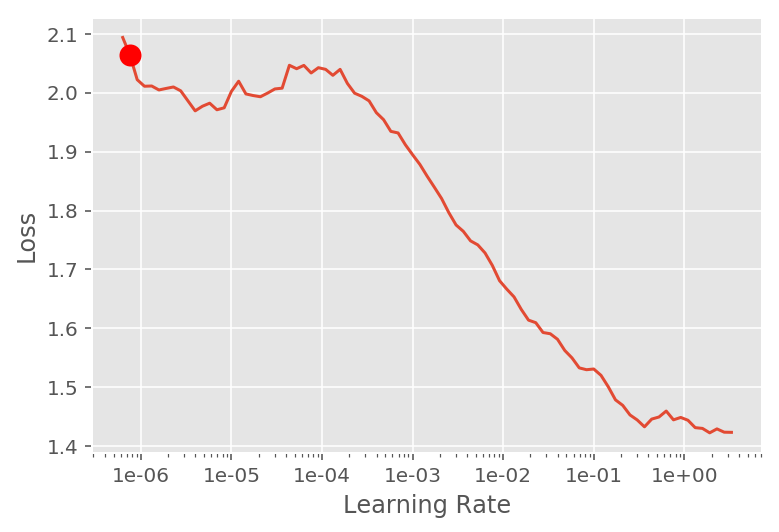

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-2
lr

0.01

In [0]:
from fastai.callbacks import SaveModelCallback

learn.fit_one_cycle(5, lr, callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='kappa_score', 
                                                     name='trial6-rd1'))])

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.848300,0.866269,0.310109,0.126900,14:49
1,0.755999,0.778180,0.273224,0.272692,08:23
2,0.781452,0.698639,0.262295,0.284979,08:26
3,0.692405,0.647986,0.230874,0.384422,08:27
4,0.629598,0.628670,0.222678,0.380466,08:31


Better model found at epoch 0 with kappa_score value: 0.12689954042434692.
Better model found at epoch 1 with kappa_score value: 0.27269208431243896.
Better model found at epoch 2 with kappa_score value: 0.2849786877632141.
Better model found at epoch 3 with kappa_score value: 0.3844221234321594.


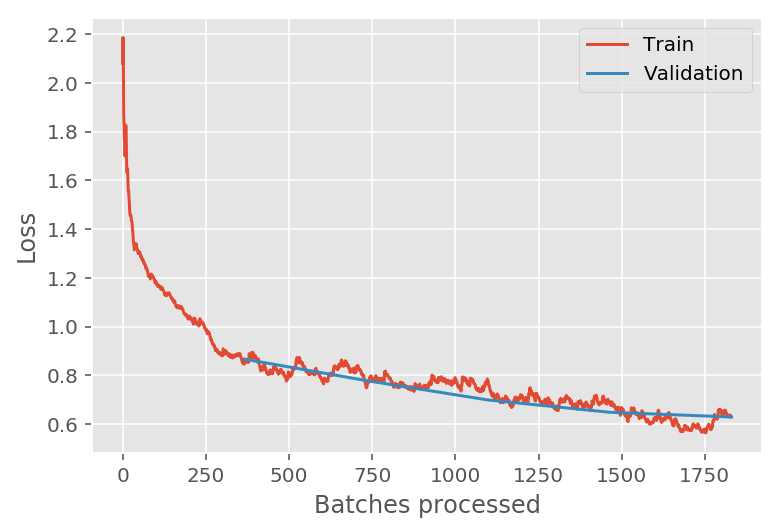

In [0]:
learn.recorder.plot_losses()

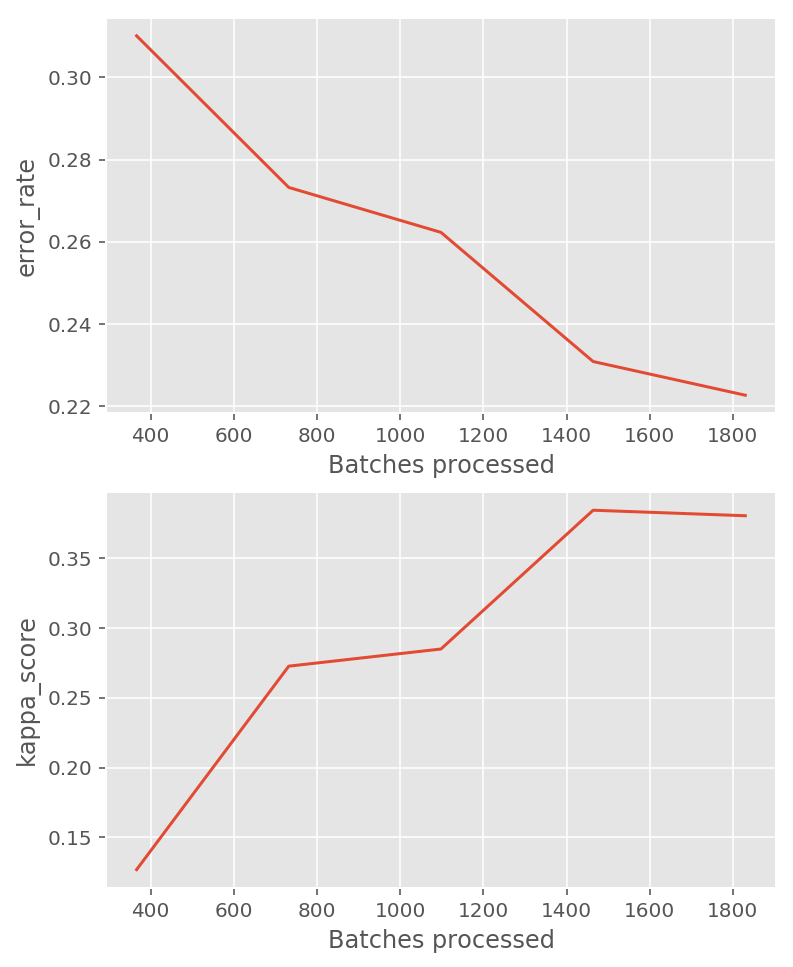

In [0]:
learn.recorder.plot_metrics()

### _Increase Image Size & Train_

In [0]:
data_128 = (ImageDataBunch.from_df(path=path/'images_train',
                              df=train_df,
                              suffix='.png',
                              size=128,
                              bs=8))

In [0]:
data_128.normalize(imagenet_stats)
# add test set
data_128.add_test(ImageList.from_df(test_df, path = path/'images_test', suffix='.png'))

In [0]:
# load weights from previous round of training
learn.load(path/'models/models/trial6-rd1');

In [0]:
learn.freeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-06
Min loss divided by 10: 9.12E-08


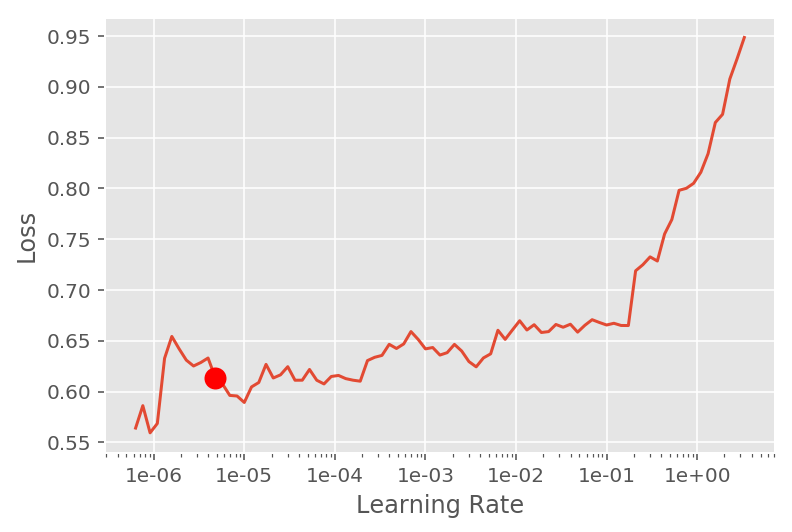

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = learn.recorder.min_grad_lr
lr

4.7863009232263826e-06

In [0]:
learn.fit_one_cycle(5, lr, callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='kappa_score', 
                                                     name='trial6-rd2'))])

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.625197,0.640544,0.228142,0.391325,08:39
1,0.593000,0.653869,0.232240,0.329655,08:28
2,0.630193,0.638008,0.232240,0.391043,08:36
3,0.634175,0.638270,0.233607,0.391532,08:37
4,0.632813,0.647273,0.229508,0.388821,08:38


Better model found at epoch 0 with kappa_score value: 0.39132487773895264.
Better model found at epoch 3 with kappa_score value: 0.3915318250656128.


### _Unfreeze Lower Layers and Train_

In [0]:
# load weights from previous round of training
learn.load(path/'models/models/trial6-rd2');

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.91E-05


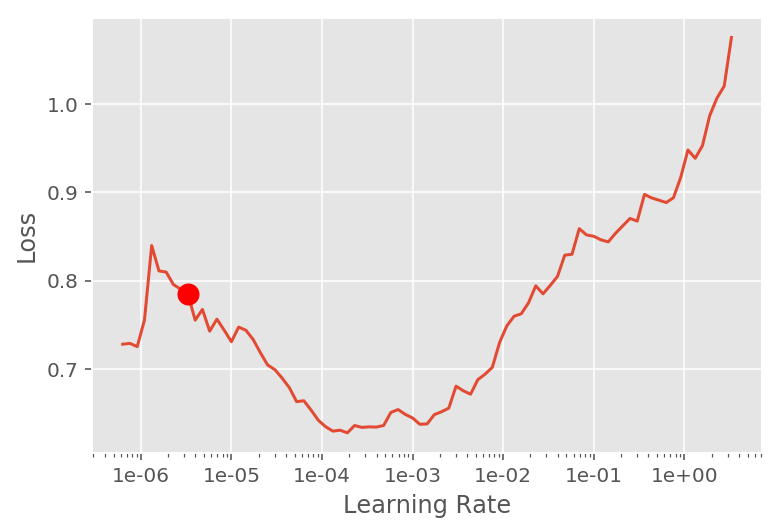

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = 5.5e-05
lr

5.5e-05

In [0]:
learn.fit_one_cycle(4, slice(lr), callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='kappa_score', 
                                                     name='trial6-rd3'))])

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.593876,0.642838,0.230874,0.394456,08:54
1,0.582704,0.622739,0.221311,0.437744,08:44
2,0.610593,0.622604,0.218579,0.431782,08:37
3,0.592289,0.623591,0.214481,0.422782,08:47


Better model found at epoch 0 with kappa_score value: 0.39445555210113525.
Better model found at epoch 1 with kappa_score value: 0.4377443194389343.


# __WORK ABOVE IS FROM AUG. 17; CONTINUE FROM HERE__

[`sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)

In [0]:
# create a sample of original dataset
train_sample = train_df.sample(frac=0.5, replace=True, random_state=1)

In [0]:
train_sample.head()

,id_code,diagnosis
1061,4beeca5cc859,0
235,1120f6d08d95,2
1096,4dbce359d0e1,2
905,417f408ee8e0,2
2763,bf6cbccacf39,0


In [0]:
# check value counts
train_sample['diagnosis'].value_counts()

0    934
2    493
1    171
4    134
3     99
Name: diagnosis, dtype: int64

In [0]:
# create target column that generates more descriptive labels vs. integer values
train_sample['target'] = train_sample['diagnosis'].map(dr_dict)

In [0]:
# check value counts
train_sample['target'].value_counts()

No DR               934
Moderate            493
Mild                171
Proliferative DR    134
Severe               99
Name: target, dtype: int64

In [0]:
# drop diagnosis column
train_sample.drop(labels='diagnosis', axis=1, inplace=True)

In [0]:
# get weights for sample data set
sample_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(train_sample['target']), 
                                                  train_sample['target'])

In [0]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [0]:
sample_weights = torch.FloatTensor(sample_weights).cuda()
learn.loss = nn.CrossEntropyLoss(weight=sample_weights)

In [0]:
data_256 = (ImageDataBunch.from_df(path=path/'images_train',
                              df=train_sample,
                              suffix='.png',
                              size=256,
                              bs=8))

In [0]:
data_256.normalize(imagenet_stats)
# add test set
data_256.add_test(ImageList.from_df(test_df, path = path/'images_test', suffix='.png'))

In [0]:
learn.data = data_256

In [0]:
# load weights from previous round of training
learn.load(path/'models/models/trial6-rd3');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 2.51E-02


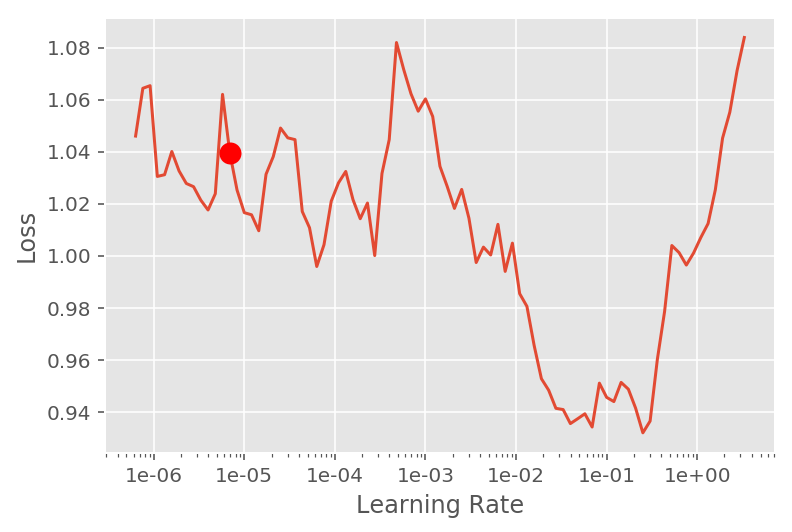

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-2
lr

0.01

In [0]:
from fastai.callbacks import SaveModelCallback

learn.fit_one_cycle(4, slice(lr), callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='kappa_score', 
                                                     name='trial6-rd4'))])

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.753472,0.594274,0.215847,0.352044,07:09
1,0.675163,0.574473,0.204918,0.354667,03:55
2,0.581163,0.515940,0.188525,0.487675,03:52
3,0.558015,0.498939,0.185792,0.537202,03:49


Better model found at epoch 0 with kappa_score value: 0.3520442843437195.
Better model found at epoch 1 with kappa_score value: 0.35466670989990234.
Better model found at epoch 2 with kappa_score value: 0.48767465353012085.
Better model found at epoch 3 with kappa_score value: 0.5372021198272705.


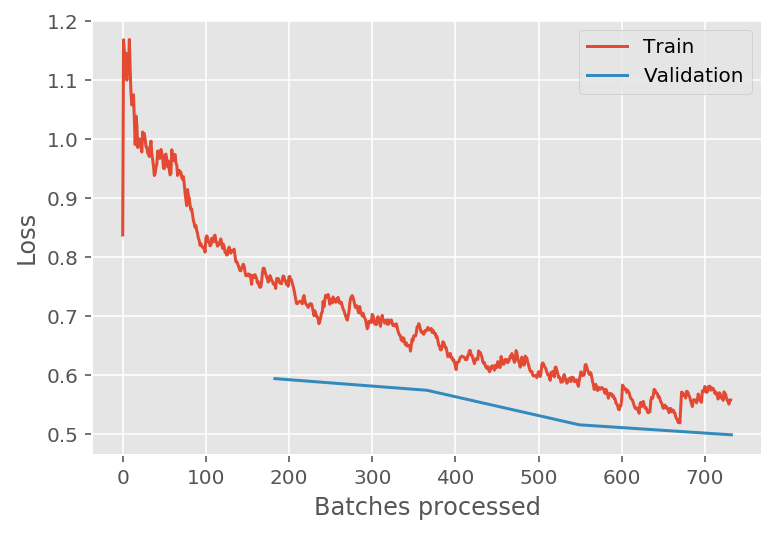

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.fit_one_cycle(2, slice(lr), callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='kappa_score', 
                                                     name='trial6-rd5'))])

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.535272,0.557995,0.202186,0.547030,03:50
1,0.478913,0.490850,0.169399,0.606895,03:48


Better model found at epoch 0 with kappa_score value: 0.5470297336578369.
Better model found at epoch 1 with kappa_score value: 0.6068952083587646.


In [0]:
learn.fit_one_cycle(2, slice(lr), callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='kappa_score', 
                                                     name='trial6-rd6'))])

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.523643,0.536756,0.196721,0.470063,03:52
1,0.444276,0.494726,0.155738,0.634280,03:52


Better model found at epoch 0 with kappa_score value: 0.4700630307197571.
Better model found at epoch 1 with kappa_score value: 0.6342795491218567.


### _Increase Image Size and Train_

In [0]:
256 + 64

320

In [0]:
data_384 = (ImageDataBunch.from_df(path=path/'images_train',
                              df=train_sample,
                              suffix='.png',
                              size=384,
                              bs=8))

In [0]:
data_384.normalize(imagenet_stats)
# add test set
data_384.add_test(ImageList.from_df(test_df, path = path/'images_test', suffix='.png'))

In [0]:
learn.data = data_384

In [0]:
# load weights from previous round of training
learn.load(path/'models/models/trial6-rd6');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-07


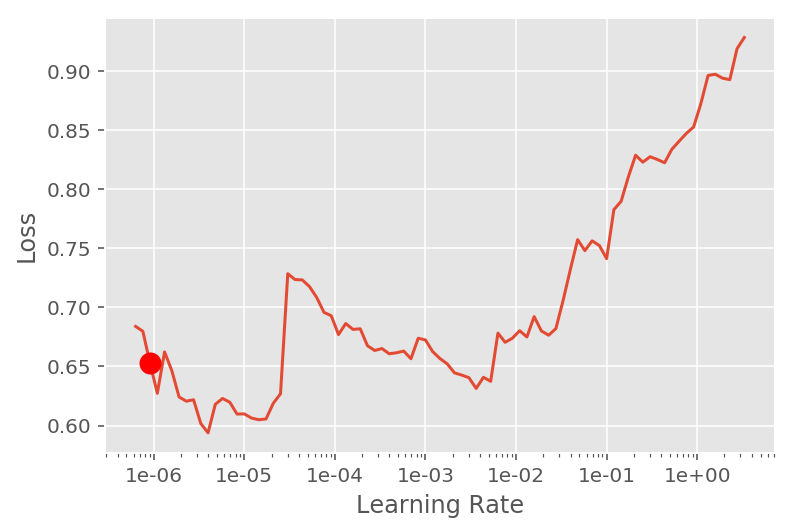

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-05
Min loss divided by 10: 4.79E-05


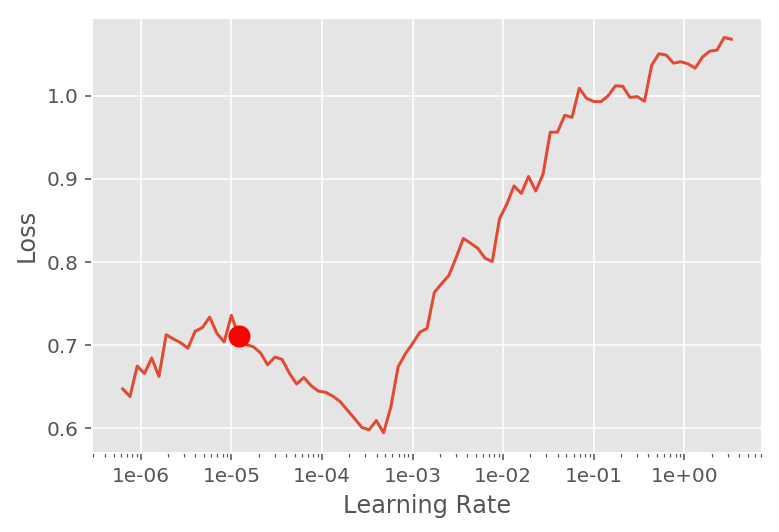

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = learn.recorder.min_grad_lr
lr

1.202264434617413e-05

In [0]:
lr/10

1.202264434617413e-06

In [0]:
learn.lr_range(slice(lr))

array([1.202264e-06, 1.202264e-06, 1.202264e-05])

In [0]:
learn.fit_one_cycle(5, slice(lr), callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='kappa_score', 
                                                     name='trial6-rd7'))])

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.623646,0.496324,0.177596,0.649617,04:29
1,0.643504,0.481252,0.183060,0.599687,04:23
2,0.600745,0.488778,0.191257,0.610803,04:24
3,0.622853,0.474697,0.188525,0.598102,04:22
4,0.631832,0.476514,0.188525,0.614843,04:23


Better model found at epoch 0 with kappa_score value: 0.649617075920105.


In [0]:
!pip install radam

  ERROR: Could not find a version that satisfies the requirement radam (from versions: none)
ERROR: No matching distribution found for radam


In [0]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [0]:
optar = partial(RAdam)

In [0]:
learn.opt_func = optar

In [0]:
# load weights from previous round of training
learn.load(path/'models/models/trial6-rd7');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-06
Min loss divided by 10: 5.75E-05


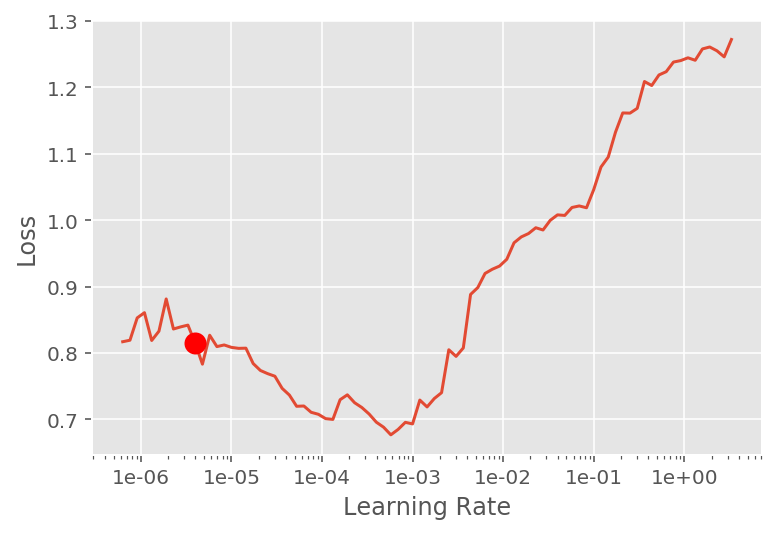

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = (1e-5 + 1e-4) / 2
lr

5.5e-05

In [0]:
learn.fit_one_cycle(5, slice(lr), callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='kappa_score', 
                                                     name='trial6-rd8'))])

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.651550,0.476836,0.183060,0.595436,04:27
1,0.636555,0.454358,0.185792,0.612045,04:26
2,0.575529,0.450479,0.169399,0.649385,04:24
3,0.594505,0.454281,0.163934,0.660235,04:22
4,0.549534,0.446376,0.169399,0.677814,04:24


Better model found at epoch 0 with kappa_score value: 0.5954360961914062.
Better model found at epoch 1 with kappa_score value: 0.6120450496673584.
Better model found at epoch 2 with kappa_score value: 0.649384617805481.
Better model found at epoch 3 with kappa_score value: 0.6602354645729065.
Better model found at epoch 4 with kappa_score value: 0.6778138279914856.


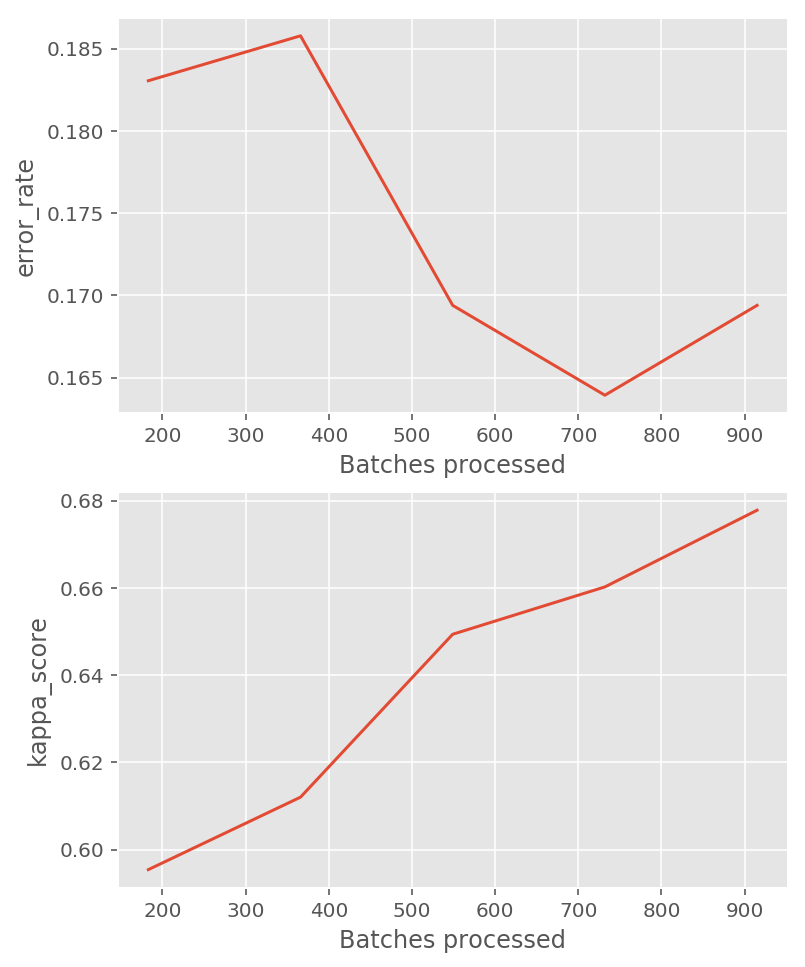

In [0]:
learn.recorder.plot_metrics()

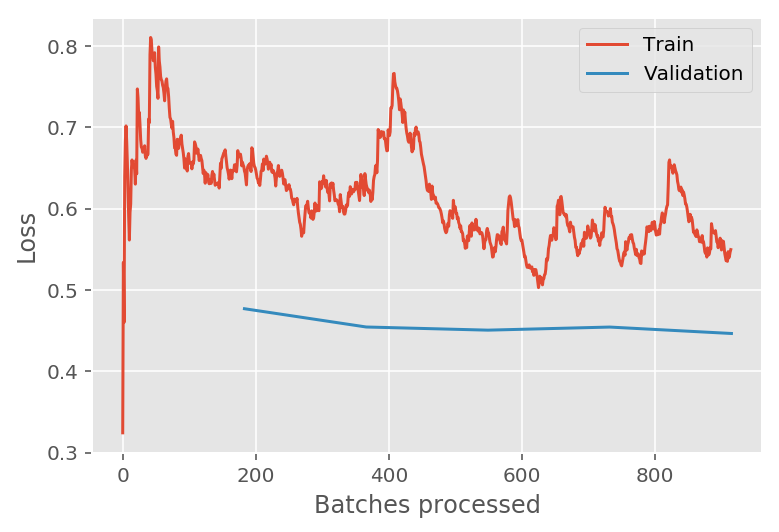

In [0]:
learn.recorder.plot_losses()

In [0]:
# load weights from previous round of training
learn.load(path/'models/models/trial6-rd8');

In [0]:
learn.freeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.45E-04


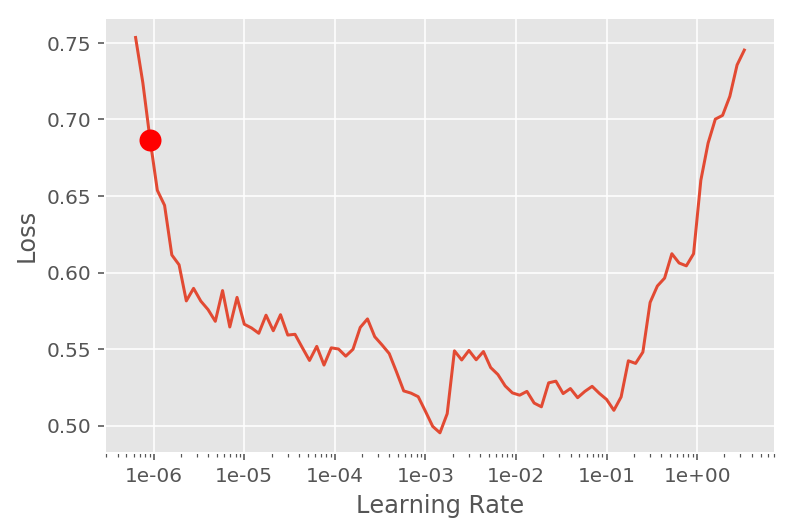

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
(learn.recorder.min_grad_lr), lr

(9.120108393559096e-07, 5.5e-05)

In [0]:
learn.fit_one_cycle(5, callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='kappa_score', 
                                                     name='trial6-rd9'))])

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.560010,0.444668,0.153005,0.678474,04:23
1,0.601087,0.445679,0.172131,0.600506,04:21
2,0.561670,0.430424,0.163934,0.687003,04:18
3,0.498108,0.438968,0.147541,0.743924,04:19
4,0.559607,0.435567,0.153005,0.698948,04:19


Better model found at epoch 0 with kappa_score value: 0.6784742474555969.
Better model found at epoch 2 with kappa_score value: 0.6870031356811523.
Better model found at epoch 3 with kappa_score value: 0.7439243793487549.


### _Increase Image Size and Train_

In [0]:
data_512 = (ImageDataBunch.from_df(path=path/'images_train',
                              df=train_sample,
                              suffix='.png',
                              size=512,
                              bs=8))

In [0]:
data_512.normalize(imagenet_stats)
# add test set
data_512.add_test(ImageList.from_df(test_df, path = path/'images_test', suffix='.png'))

In [0]:
learn.data = data_512

In [0]:
# load weights from previous round of training
learn.load(path/'models/models/trial6-rd9');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04
Min loss divided by 10: 6.31E-08


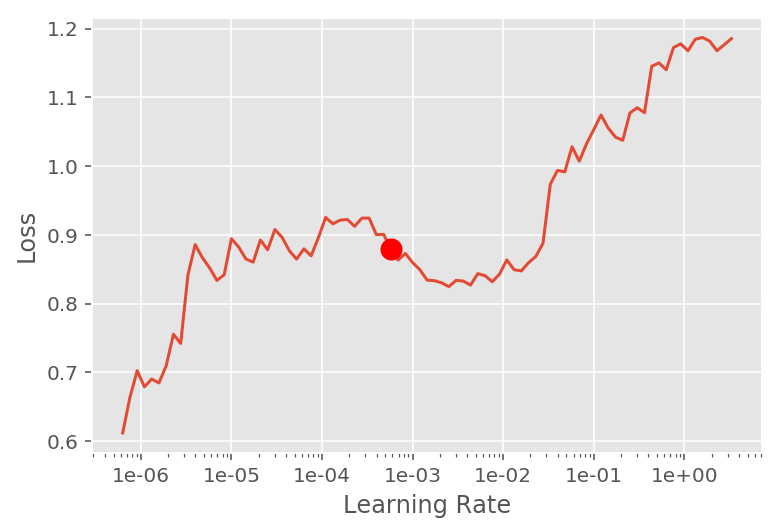

In [0]:
learn.recorder.plot(suggestion=True)

# __LEFT OFF HERE AUG.18__